In [2]:
# import package
import torch
import torch.nn as nn
import torchvision.models as model
import torchsummary
from torchsummary import summary
from torch.utils import data
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
# import cv2
import scipy.io as matlabio
import scipy.signal as sig
import codecs
import struct
import re
import pandas as pd
import myLib
import os, glob
from torch.utils.data import random_split
import importlib
import glob
import myLib
from tqdm import tqdm
import custom_module
import pathlib
import random
import shutil
from scipy import optimize as op
import os
import time
import my_loss_func as lf
importlib.reload(myLib)
importlib.reload(custom_module)

<module 'custom_module' from 'd:\\DaMing\\code\\python\\python\\custom_module.py'>

In [2]:
# optimize the number of features by iteration (dimentionality reduction)

import numpy as np
import pandas as pd
import pymrmr
import mrmr
import sklearn_relief as relief
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.preprocessing as prep
from sklearn.pipeline import make_pipeline
import shap
from sklearn import svm
from xgboost.sklearn import XGBClassifier
import lightgbm as lgbm
from sklearn import decomposition
from sklearn.feature_selection import RFE

def data_normalization(classifier, data):
    if classifier == 'SVM':
        return prep.StandardScaler().fit_transform(data)
    else:
        return prep.MaxAbsScaler().fit_transform(data)

# feature_reduction = 'relief'
# classfier = "XGB"
# reduced_dimension = 50
process = [("SVM", 'pca'),
           ("SVM", 'mrmr'),
           ("SVM", 'relief')]
rep = 5
data_dir = rf'D:\DaMing\contusion_classification'
data_path = rf'{data_dir}\data.xlsx'
label_path = rf'{data_dir}\label.xlsx'
data = pd.read_excel(data_path)
label = pd.read_excel(label_path).squeeze().to_numpy()
max_feature_num = len(data.columns)
x_feature_names = data.columns

dim_range = np.arange(5, max_feature_num, 5)
train_acc = np.zeros((rep, dim_range.shape[0]))
val_acc = np.zeros((rep, dim_range.shape[0]))

for classifier, feature_reduction in process:
    for r in range(0, rep):
        for i in range(0, dim_range.shape[0]):
            reduced_dimension = dim_range[i]
            if feature_reduction == 'pca':
                scale_data = data_normalization(classifier, data)
                pca = decomposition.PCA(n_components=reduced_dimension)
                reduced_data = pca.fit_transform(scale_data)
            elif feature_reduction == 'mrmr':
                sf  = mrmr.mrmr_classif(X=data, y=label, K=reduced_dimension)
                reduced_data = data_normalization(classifier, data[sf])
            elif feature_reduction == 'rfe':
                reduced_data = data_normalization(classifier, data)
                if classifier=="SVM":
                    clf = svm.SVC(kernel='rbf', C=1, gamma='auto', probability=True)
                elif classifier=="XGB":
                    # importance_type='gain' should be given to generate feature_importances_ for further performance evaluation by RFE
                    clf = XGBClassifier(importance_type='gain')
                else:
                    clf = lgbm.LGBMClassifier(importance_type='gain')
                sf = RFE(estimator=clf, n_features_to_select=reduced_dimension)
                reduced_data = sf.fit_transform(reduced_data, label)
            elif feature_reduction == 'relief':
                scale_data = data_normalization(classifier, data)
                rl = relief.Relief(n_features=reduced_dimension, n_jobs=1) # Choose the best 3 features
                # r = relief.ReliefF(n_features=reduced_dimension, n_jobs=1)
                # r = relief.RReliefF(n_features=reduced_dimension, n_jobs=1)
                reduced_data = rl.fit_transform(scale_data, label)
            else:
                reduced_data = data_normalization(classifier, data)

            X_train, X_test, y_train, y_test = train_test_split(reduced_data, label, test_size=0.2)

            # 這邊有做正規化，沒有做結果會差很多
            if classifier=="SVM":
                clf = svm.SVC(kernel='rbf', C=1, gamma='auto', probability=True)
            elif classifier=="XGB":
                clf = XGBClassifier()
            else:
                clf = lgbm.LGBMClassifier()
                # clf = lgbm.LGBMClassifier(min_child_samples=40, num_leaves=127, max_depth=9, learning_rate=0.5, n_estimators=45)
            clf.fit(X_train,y_train)
            
            train_acc[r, i] = clf.score(X_train, y_train)
            val_acc[r, i] = clf.score(X_test, y_test)
        
        # print(rf'train: {train_acc[i]}')
        # print(rf'validation: {val_acc[i]}')
    np.save(rf'{data_dir}\{classifier}_{feature_reduction}_{rep}rep_train_acc', train_acc)
    np.save(rf'{data_dir}\{classifier}_{feature_reduction}_{rep}rep_val_acc', val_acc)

KeyboardInterrupt: 

[0.76720257 0.82057878 0.88424437 0.88360129 0.89967846 0.89903537
 0.89903537 0.91125402 0.90675241 0.89324759 0.88874598 0.89389068
 0.89646302 0.88360129 0.87845659 0.89967846 0.88745981 0.88810289
 0.88938907 0.88681672 0.88745981 0.89067524 0.87395498 0.87652733
 0.88874598 0.88874598 0.85916399 0.86302251 0.87909968 0.87266881
 0.88424437 0.88938907 0.86109325 0.87652733 0.88167203 0.86881029
 0.86109325 0.86688103 0.8977492  0.86173633 0.87459807 0.87717042
 0.87138264]


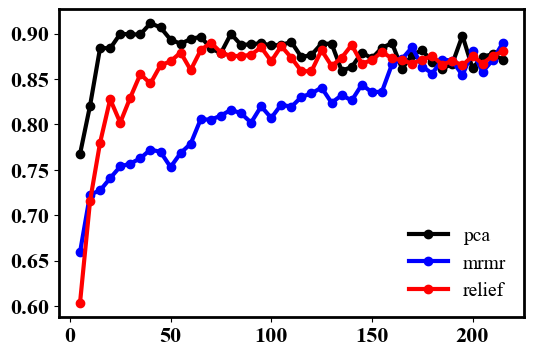

In [77]:
# show the result of dimentionality reduction methods as a function of feature numbers

fig = plt.figure(figsize=(6,4), edgecolor='blue')
classfier = 'LGBM'
# result_dir = rf'D:\DaMing\contusion_classification\feature_6_39__0_45degree'
result_dir = rf'D:\DaMing\contusion_classification'
data = np.load(rf'{result_dir}\{classfier}_pca_5rep_val_acc.npy')
plt.plot(5*np.arange(1, data.shape[1]+1), data.mean(axis=0), marker='o', linewidth=3, color='black')
# plt.errorbar(5*np.arange(1, data.shape[0]+1), data, yerr=std, fmt="o", capsize=3, color='black', ecolor='black')
print(data.mean(axis=0))

data = np.load(rf'{result_dir}\{classfier}_mrmr_5rep_val_acc.npy')
plt.plot(5*np.arange(1, data.shape[1]+1), data.mean(axis=0), marker='o', linewidth=3, color='blue')

data = np.load(rf'{result_dir}\{classfier}_relief_5rep_val_acc.npy')
plt.plot(5*np.arange(1, data.shape[1]+1), data.mean(axis=0), marker='o', linewidth=3, color='red')

plt.xticks(fontsize=16, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=16, fontweight='bold', fontfamily='Times New Roman')
plt.legend(labels=['pca', 'mrmr', 'relief'], loc='lower right', edgecolor='None', prop={'family':'Times New Roman', 'size':14})
ax = fig.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 1241, number of used features: 70
[LightGBM] [Info] Start training from score -2.488944
[LightGBM] [Info] Start training from score -1.380670
[LightGBM] [Info] Start training from score -1.005576
[LightGBM] [Info] Start training from score -1.204779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[Text(0, 0, 'corrm__4_26__90'),
 Text(0, 1, 'contr__4_26__90'),
 Text(0, 2, 'inf2h__4_26__45'),
 Text(0, 3, 'inf2h__6_39__90'),
 Text(0, 4, 'nakagami'),
 Text(0, 5, 'inf1h__6_39__90'),
 Text(0, 6, 'inf1h__4_26__90'),
 Text(0, 7, 'swa'),
 Text(0, 8, 'IB'),
 Text(0, 9, 'SNR')]

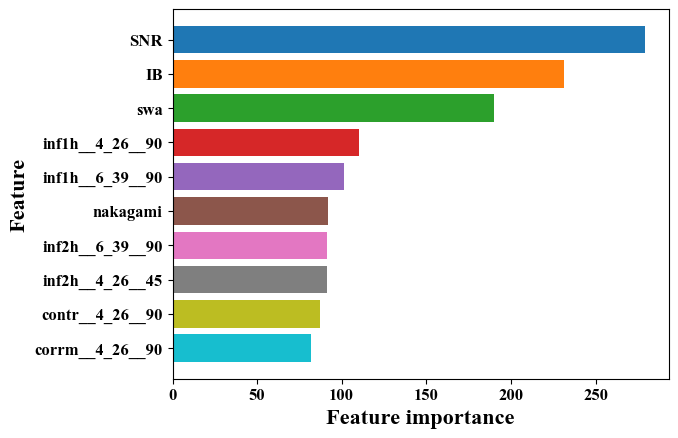

In [7]:
import numpy as np
import pandas as pd
# import pymrmr
import mrmr
import sklearn_relief as relief
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.preprocessing as prep
from sklearn.pipeline import make_pipeline
from sklearn import decomposition
import shap
import sklearn
from sklearn.feature_selection import RFE
from sklearn import svm
from xgboost.sklearn import XGBClassifier
import lightgbm as lgbm
import matplotlib


matplotlib.interactive('True')
feature_reduction = 'relief'
classifier = "LGBM"
reduced_dimension = 70

# data_path = rf'D:\DaMing\contusion_classification\feature_6_39__0_45degree\data.xlsx'
# label_path = rf'D:\DaMing\contusion_classification\feature_6_39__0_45degree\label.xlsx'
data_path = rf'D:\DaMing\contusion_classification\data.xlsx'
label_path = rf'D:\DaMing\contusion_classification\label.xlsx'
data = pd.read_excel(data_path)
label = pd.read_excel(label_path).squeeze().to_numpy()
# max_feature_num = len(data.columns)
x_feature_names = data.columns

# -regularization, performance significantly decreases without regularization for svm (StandardScaler is most suitable for svm)
# -while only minor improvement occurs for XGB and LGBM (MaxAbsScaler for the two) 
def data_normalization(classifier, data):
    if classifier == 'SVM':
        return prep.StandardScaler().fit_transform(data)
    else:
        return prep.MaxAbsScaler().fit_transform(data)

if feature_reduction == 'pca':
    scale_data = data_normalization(classifier, data)
    pca = decomposition.PCA(n_components=reduced_dimension)
    reduced_data = pca.fit_transform(scale_data)
elif feature_reduction == 'mrmr':
    sf  = mrmr.mrmr_classif(X=data, y=label, K=reduced_dimension)
    reduced_data = data_normalization(classifier, data[sf])
elif feature_reduction == 'rfe':
    reduced_data = data_normalization(classifier, data)
    if classifier=="SVM":
        clf = svm.SVC(kernel='rbf', C=1, gamma='auto', probability=True)
    elif classifier=="XGB":
        # importance_type='gain' should be given to generate feature_importances_ for further performance evaluation by RFE
        clf = XGBClassifier(importance_type='gain')
    else:
        clf = lgbm.LGBMClassifier(importance_type='gain')
    sf = RFE(estimator=clf, n_features_to_select=reduced_dimension)
    reduced_data = sf.fit_transform(reduced_data, label)
elif feature_reduction == 'relief':
    scale_data = data_normalization(classifier, data)
    r = relief.Relief(n_features=reduced_dimension, n_jobs=1) # Choose the best 3 features
    # r = relief.ReliefF(n_features=reduced_dimension, n_jobs=1)
    # r = relief.RReliefF(n_features=reduced_dimension, n_jobs=1)
    r.fit(scale_data, label)
    
    temp = np.argsort(r.w_)[::-1]
    x_feature_names = x_feature_names[temp[0:reduced_dimension]]
    
    reduced_data = r.transform(scale_data)
else:
    reduced_data = data_normalization(classifier, data)
    
X_train, X_test, y_train, y_test = train_test_split(reduced_data, label, test_size=0.2, random_state=299)


if classifier=="SVM":
    clf = svm.SVC(kernel='rbf', C=1, gamma='auto', probability=True)
elif classifier=="XGB":
    clf = XGBClassifier()
else:
    # clf = lgbm.LGBMClassifier()
    clf = lgbm.LGBMClassifier(min_child_samples=40, num_leaves=127, max_depth=9, learning_rate=0.5, n_estimators=45)
clf.fit(X_train,y_train)
importance = clf.feature_importances_
print(clf.score(X_train,y_train))
print(clf.score(X_test, y_test))

sort_importance_idx = np.argsort(importance)[::-1]
sort_importance = np.sort(importance)[::-1]
for i in range(0, 10):
    plt.barh(9-i, sort_importance[i])
ax = plt.gca()
plt.xlabel('Feature importance', fontsize=16, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel('Feature', fontsize=16, fontweight='bold', fontfamily='Times New Roman')
plt.xticks(fontsize=12, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(np.arange(0, 10))
ax.set_yticklabels(x_feature_names[sort_importance_idx[0:10]][::-1], fontsize=12, fontweight='bold', fontfamily='Times New Roman')

# pc_weight = pca.explained_variance_ratio_
# temp = 0
# for i in range(0, 9):
#     plt.barh(10, pc_weight[i], left=temp)
#     temp += pc_weight[i]
# plt.barh(10, pc_weight[9:].sum(), left=temp)

# base_weight = np.absolute(pca.components_)
# for i in range(0, base_weight.shape[0]):
#     base_weight[i, :] = pc_weight[i]*base_weight[i, :]
# sort_base = np.sort(base_weight.sum(axis=0))[::-1]
# sort_base_index = np.argsort(base_weight.sum(axis=0))[::-1]
# temp = 0
# for i in range(10):
#     plt.barh(9-i, sort_base[i])
#     # temp += sort_base[i]/sort_base.sum()
# # print(sort_base)
# print(data.columns[sort_base_index])
# temp = data.columns[sort_base_index].values[0:10][::-1]
# plt.xlabel('Weight (a.u.)', fontsize=24, fontweight='bold', fontfamily='Times New Roman')
# plt.xticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')
# ax = plt.gca()
# plt.yticks(np.arange(0, 11))
# # plt.yticks(np.concatenate((temp, np.array(['PC weight']))), fontsize=20, fontweight='bold', fontfamily='Times New Roman')
# ax.set_yticklabels(np.concatenate((temp, np.array(['PC weight']))), fontsize=12, fontweight='bold', fontfamily='Times New Roman')
# plt.show()

# class_names = ['normal', 'destruction', 'repair', 'remodeling']
# explainer = shap.KernelExplainer(model=clf.predict_proba, data=X_test, link='logit')
# shap_values = explainer.shap_values(X=X_test)
# # This line can only run on jupyter and show visual picture of shapley value
# shap.summary_plot(shap_values[0], X_test, max_display=10, class_names= class_names, feature_names = x_feature_names)

In [24]:
import optuna
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
import sklearn.preprocessing as prep
import xgboost as xgb
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import joblib
from sklearn import decomposition

data_path = rf'D:\DaMing\contusion_classification\data.xlsx'
label_path = rf'D:\DaMing\contusion_classification\label.xlsx'
data = pd.read_excel(data_path).to_numpy()
label = pd.read_excel(label_path).squeeze().to_numpy()
reduced_dimension = 40

scale_data = prep.MaxAbsScaler().fit_transform(data)
pca = decomposition.PCA(n_components=reduced_dimension)
reduced_data = pca.fit_transform(scale_data)
X_train, X_test, y_train, y_test = train_test_split(reduced_data, label, test_size=0.2, random_state=2)

def objective(trial):
    """
    A function to train a model using different hyperparamerters combinations provided by Optuna.
    """
    params = {
        'min_child_samples':trial.suggest_categorical('min_child_samples', [10, 15, 20, 25, 30, 35, 40, 45, 50]),
        'num_leaves': trial.suggest_categorical('num_leaves', [3, 7, 15, 31, 63, 127, 255]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 7, 9, 11, 13, 15, 17, 19]),
        'learning_rate': trial.suggest_categorical('learning_rate', [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]),
        'n_estimators': trial.suggest_categorical('n_estimators', [5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
    }
    clf = lgbm.LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

search_space = {
    'min_child_samples':[10, 15, 20, 25, 30, 35, 40, 45, 50],
    'num_leaves': [3, 7, 15, 31, 63, 127, 255],
    'max_depth': [5, 7, 9, 11, 13, 15, 17, 19],
    'learning_rate': [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001],
    'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
}
study = optuna.create_study(sampler=optuna.samplers.GridSampler(search_space), direction='maximize')
study.optimize(objective, n_trials = 9*7*8*7*10)
# study.optimize(objective, n_trials = 1)
joblib.dump(study, rf'D:\DaMing\contusion_classification\study3.pkl')
# print(study.best_trial)
print(study.best_params)
# print(study.best_value)


[I 2024-02-19 17:44:06,273] A new study created in memory with name: no-name-229dff3d-91b9-43c3-9aeb-df5b09325c9c
[I 2024-02-19 17:44:06,287] Trial 0 finished with value: 0.33762057877813506 and parameters: {'min_child_samples': 35, 'num_leaves': 7, 'max_depth': 13, 'learning_rate': 0.005, 'n_estimators': 5}. Best is trial 0 with value: 0.33762057877813506.
[I 2024-02-19 17:44:06,308] Trial 1 finished with value: 0.7138263665594855 and parameters: {'min_child_samples': 45, 'num_leaves': 3, 'max_depth': 11, 'learning_rate': 1, 'n_estimators': 15}. Best is trial 1 with value: 0.7138263665594855.
[I 2024-02-19 17:44:06,346] Trial 2 finished with value: 0.572347266881029 and parameters: {'min_child_samples': 40, 'num_leaves': 7, 'max_depth': 19, 'learning_rate': 0.01, 'n_estimators': 40}. Best is trial 1 with value: 0.7138263665594855.
[I 2024-02-19 17:44:06,417] Trial 3 finished with value: 0.8938906752411575 and parameters: {'min_child_samples': 15, 'num_leaves': 255, 'max_depth': 7, 'le

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 1241, number of used features: 40
[LightGBM] [Info] Start training from score -2.423192
[LightGBM] [Info] Start training from score -1.393573
[LightGBM] [Info] Start training from score -0.996804
[LightGBM] [Info] Start training from score -1.223775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 1241, number of used features: 40
[LightGBM] [Info] Start training from score -2.423192
[LightGBM] [Info] Start training from score -1.393573
[LightGBM] [Info] Start training from score -0.996804
[LightGBM] [Info] Start training from score 

[I 2024-02-19 17:44:06,500] Trial 4 finished with value: 0.6334405144694534 and parameters: {'min_child_samples': 35, 'num_leaves': 31, 'max_depth': 7, 'learning_rate': 0.005, 'n_estimators': 45}. Best is trial 3 with value: 0.8938906752411575.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-02-19 17:44:06,774] Trial 5 finished with value: 0.8488745980707395 and parameters: {'min_child_samples': 10, 'num_leaves': 255, 'max_depth': 17, 'learning_rate': 0.05, 'n_estimators': 40}. Best is trial 3 with value: 0.8938906752411575.
[I 2024-02-19 17:44:06,796] Trial 6 finished with value: 0.33762057877813506 and parameters: {'min_child_samples': 50, 'num_leaves': 255, 'max_depth': 19, 'learning_rate': 0.01, 'n_estimators': 5}. Best is trial 3 with value: 0.8938906752411575.
[I 2024-02-19 17:44:06,842] Trial 7 finished with value: 0.35691318327974275 and parameters: {'min_child_samples': 25, 'num_leaves': 31, 'max_depth': 13, 'learning_rate': 0.005, 'n_estimators': 15}. Best is trial 3 with value: 0.8938906752411575.
[I 2024-02-19 17:44:06,864] Trial 8 finished with value: 0.7620578778135049 and parameters: {'min_child_samples': 35, 'num_leaves': 7, 'max_depth': 9, 'learning_rate': 0.5, 'n_estimators': 10}. Best is trial 3 with value: 0.8938906752411575.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-02-19 17:44:06,903] Trial 9 finished with value: 0.6237942122186495 and parameters: {'min_child_samples': 15, 'num_leaves': 7, 'max_depth': 19, 'learning_rate': 0.05, 'n_estimators': 10}. Best is trial 3 with value: 0.8938906752411575.
[I 2024-02-19 17:44:06,952] Trial 10 finished with value: 0.8392282958199357 and parameters: {'min_child_samples': 50, 'num_leaves': 15, 'max_depth': 9, 'learning_rate': 0.1, 'n_estimators': 35}. Best is trial 3 with value: 0.8938906752411575.
[I 2024-02-19 17:44:06,991] Trial 11 finished with value: 0.33762057877813506 and parameters: {'min_child_samples': 45, 'num_leaves': 15, 'max_depth': 15, 'learning_rate': 0.001, 'n_estimators': 25}. Best is trial 3 with value: 0.8938906752411575.
[I 2024-02-19 17:44:07,036] Trial 12 finished with value: 0.8745980707395499 and parameters: {'min_child_samples': 20, 'num_leaves': 15, 'max_depth': 15, 'learning_rate': 0.5, 'n_estimators': 30}. Best is trial 3 with value: 0.8938906752411575.
[I 2024-02-19 17:44

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 1241, number of used features: 40
[LightGBM] [Info] Start training from score -2.423192
[LightGBM] [Info] Start training from score -1.393573
[LightGBM] [Info] Start training from score -0.996804
[LightGBM] [Info] Start training from score -1.223775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 1241, number of used features: 40
[LightGBM] [Info] Start training from score -2.423192
[LightGBM] [Info] Start training from score -1.393573
[LightGBM] [Info] Start training from score -0.996804
[LightGBM] [Info] Start training from score 

[I 2024-02-19 17:44:07,154] Trial 14 finished with value: 0.6881028938906752 and parameters: {'min_child_samples': 45, 'num_leaves': 63, 'max_depth': 19, 'learning_rate': 0.01, 'n_estimators': 45}. Best is trial 3 with value: 0.8938906752411575.
[I 2024-02-19 17:44:07,179] Trial 15 finished with value: 0.7845659163987139 and parameters: {'min_child_samples': 50, 'num_leaves': 255, 'max_depth': 7, 'learning_rate': 1, 'n_estimators': 5}. Best is trial 3 with value: 0.8938906752411575.
[I 2024-02-19 17:44:07,231] Trial 16 finished with value: 0.43729903536977494 and parameters: {'min_child_samples': 25, 'num_leaves': 255, 'max_depth': 17, 'learning_rate': 0.01, 'n_estimators': 10}. Best is trial 3 with value: 0.8938906752411575.
[I 2024-02-19 17:44:07,270] Trial 17 finished with value: 0.842443729903537 and parameters: {'min_child_samples': 30, 'num_leaves': 7, 'max_depth': 15, 'learning_rate': 0.5, 'n_estimators': 40}. Best is trial 3 with value: 0.8938906752411575.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 1241, number of used features: 40
[LightGBM] [Info] Start training from score -2.423192
[LightGBM] [Info] Start training from score -1.393573
[LightGBM] [Info] Start training from score -0.996804
[LightGBM] [Info] Start training from score -1.223775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-02-19 17:44:07,305] Trial 18 finished with value: 0.7395498392282959 and parameters: {'min_child_samples': 40, 'num_leaves': 7, 'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 35}. Best is trial 3 with value: 0.8938906752411575.
[I 2024-02-19 17:44:07,327] Trial 19 finished with value: 0.33762057877813506 and parameters: {'min_child_samples': 10, 'num_leaves': 7, 'max_depth': 5, 'learning_rate': 0.01, 'n_estimators': 5}. Best is trial 3 with value: 0.8938906752411575.
[I 2024-02-19 17:44:07,360] Trial 20 finished with value: 0.842443729903537 and parameters: {'min_child_samples': 35, 'num_leaves': 7, 'max_depth': 9, 'learning_rate': 1, 'n_estimators': 30}. Best is trial 3 with value: 0.8938906752411575.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 1241, number of used features: 40
[LightGBM] [Info] Start training from score -2.423192
[LightGBM] [Info] Start training from score -1.393573
[LightGBM] [Info] Start training from score -0.996804
[LightGBM] [Info] Start training from score -1.223775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 1241, number of used features: 40
[LightGBM] [Info] Start training from score -2.423192
[LightGBM] [Info] Start training from score -1.393573
[LightGBM] [Info] Start training from score -0.996804
[LightGBM] [Info] Start training from score 

[I 2024-02-19 17:44:07,463] Trial 21 finished with value: 0.8231511254019293 and parameters: {'min_child_samples': 25, 'num_leaves': 63, 'max_depth': 9, 'learning_rate': 0.05, 'n_estimators': 35}. Best is trial 3 with value: 0.8938906752411575.
[I 2024-02-19 17:44:07,559] Trial 22 finished with value: 0.8713826366559485 and parameters: {'min_child_samples': 25, 'num_leaves': 31, 'max_depth': 13, 'learning_rate': 0.1, 'n_estimators': 40}. Best is trial 3 with value: 0.8938906752411575.
[I 2024-02-19 17:44:07,605] Trial 23 finished with value: 0.8038585209003215 and parameters: {'min_child_samples': 30, 'num_leaves': 63, 'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 20}. Best is trial 3 with value: 0.8938906752411575.
[I 2024-02-19 17:44:07,657] Trial 24 finished with value: 0.8938906752411575 and parameters: {'min_child_samples': 50, 'num_leaves': 15, 'max_depth': 7, 'learning_rate': 1, 'n_estimators': 50}. Best is trial 3 with value: 0.8938906752411575.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 1241, number of used features: 40
[LightGBM] [Info] Start training from score -2.423192
[LightGBM] [Info] Start training from score -1.393573
[LightGBM] [Info] Start training from score -0.996804
[LightGBM] [Info] Start training from score -1.223775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves O

[I 2024-02-19 17:44:07,744] Trial 25 finished with value: 0.8906752411575563 and parameters: {'min_child_samples': 50, 'num_leaves': 127, 'max_depth': 9, 'learning_rate': 0.5, 'n_estimators': 50}. Best is trial 3 with value: 0.8938906752411575.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 1241, number of used features: 40
[LightGBM] [Info] Start training from score -2.423192
[LightGBM] [Info] Start training from score -1.393573
[LightGBM] [Info] Start training from score -0.996804
[LightGBM] [Info] Start training from score -1.223775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2024-02-19 17:44:07,925] Trial 26 finished with value: 0.5691318327974276 and parameters: {'min_child_samples': 10, 'num_leaves': 127, 'max_depth': 13, 'learning_rate': 0.005, 'n_estimators': 30}. Best is trial 3 with value: 0.8938906752411575.
[I 2024-02-19 17:44:07,995] Trial 27 finished with value: 0.662379421221865 and parameters: {'min_child_samples': 45, 'num_leaves': 31, 'max_depth': 13, 'learning_rate': 0.01, 'n_estimators': 35}. Best is trial 3 with value: 0.8938906752411575.
[I 2024-02-19 17:44:08,025] Trial 28 finished with value: 0.6302250803858521 and parameters: {'min_child_samples': 40, 'num_leaves': 63, 'max_depth': 11, 'learning_rate': 0.05, 'n_estimators': 5}. Best is trial 3 with value: 0.8938906752411575.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-02-19 17:44:08,100] Trial 29 finished with value: 0.33762057877813506 and parameters: {'min_child_samples': 15, 'num_leaves': 31, 'max_depth': 5, 'learning_rate': 0.001, 'n_estimators': 40}. Best is trial 3 with value: 0.8938906752411575.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

KeyboardInterrupt: 

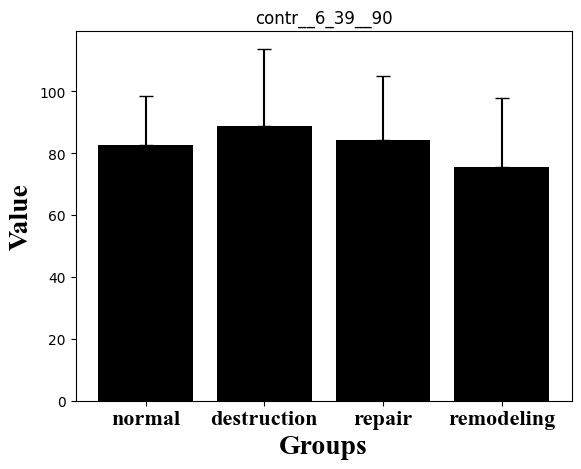

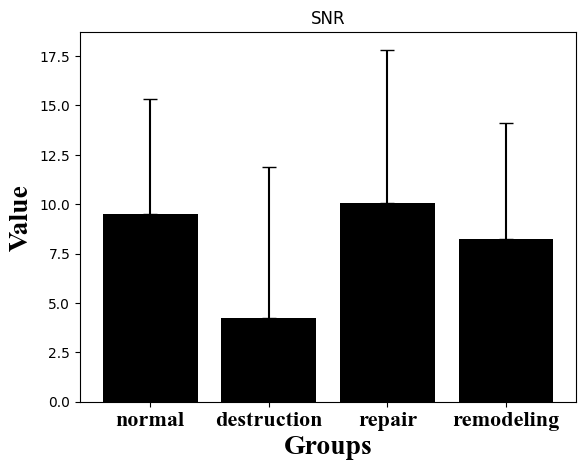

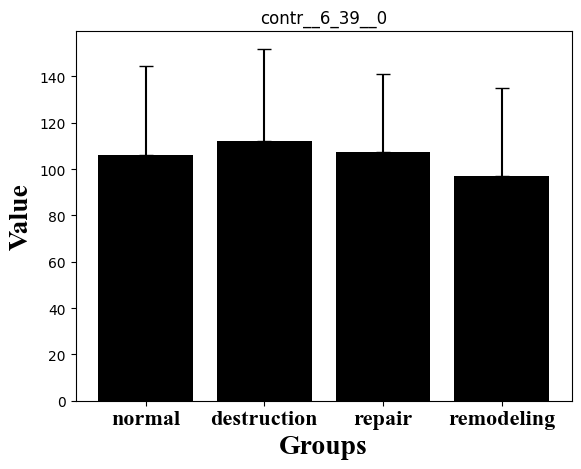

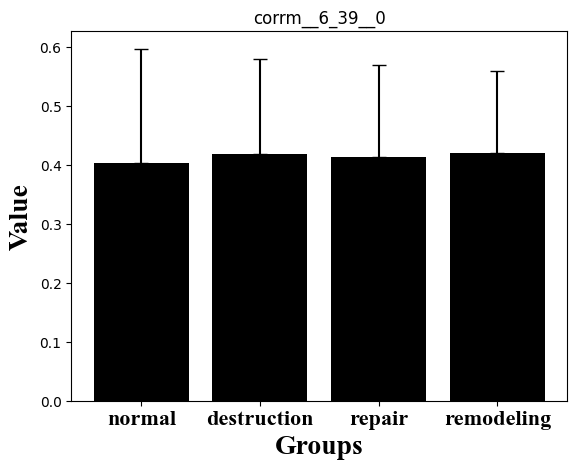

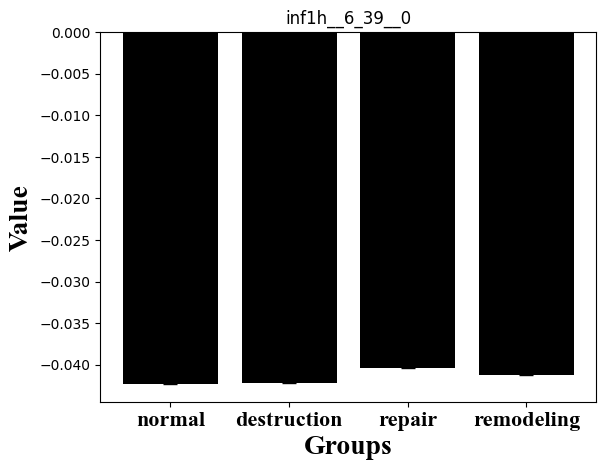

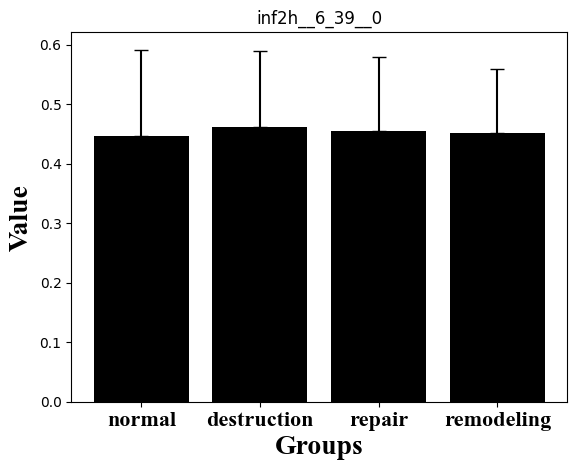

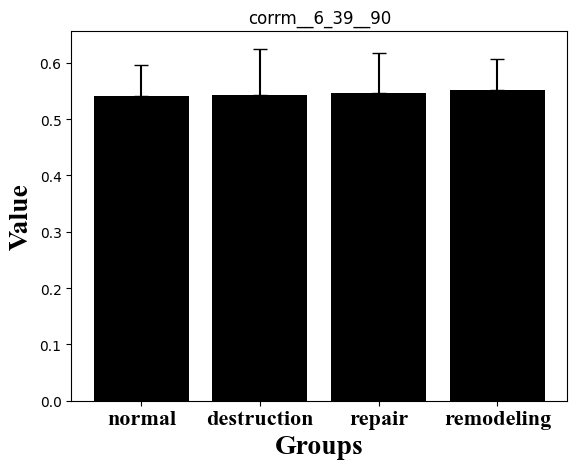

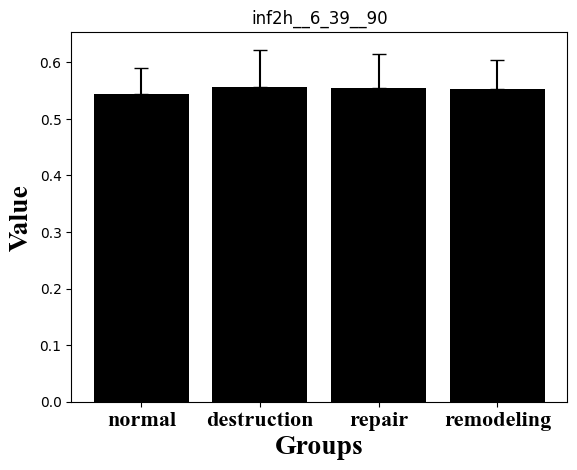

In [15]:
# data_path = rf'D:\DaMing\contusion_classification\data.xlsx'
# label_path = rf'D:\DaMing\contusion_classification\label.xlsx'
# data = pd.read_excel(data_path)
# label = pd.read_excel(label_path)
important_feature_name = ['contr__6_39__90', 'SNR', 'contr__6_39__0', 'corrm__6_39__0', 'inf1h__6_39__0', 'inf2h__6_39__0', 'corrm__6_39__90', 'inf1h__6_39__90', 'inf2h__6_39__90']
plot_name = ['SNR (dB)', 'Contrast', 'Correlation', ]
classes = ['normal', 'destruction', 'repair', 'remodeling']
# data = data.drop([186, 281, 520, 615, 985], axis=0)

important_feature_value = np.zeros((4, len(important_feature_name)))
important_feature_var = np.zeros((2, 4, len(important_feature_name)))
for i in range(0, 4):
    data[label['class']==i][important_feature_name].to_excel(rf'D:\DaMing\contusion_classification\{classes[i]}.xlsx')
    temp = data[label['class']==i][important_feature_name]
    np.save(rf'C:\Users\Buslab\Desktop\temp.npy', temp.to_numpy())
    important_feature_value[i, :] = data[label['class']==i][important_feature_name].mean().to_numpy()
    important_feature_var[1, i, :] = data[label['class']==i][important_feature_name].std().to_numpy()

for i in range(0, len(important_feature_name)):
    plt.bar(classes, important_feature_value[:, i], yerr=important_feature_var[:, :, i], color='black', capsize=5, ecolor='black')
    plt.title(important_feature_name[i])
    plt.xlabel('Groups', fontsize=20, fontfamily='Times new roman', fontweight='bold')
    plt.ylabel('Value', fontsize=20, fontfamily='Times new roman', fontweight='bold')
    plt.xticks(fontsize=16, fontweight='bold', fontfamily='Times New Roman')
    # plt.yticks(np.arange(0, 25, 2.5), fontsize=16, fontweight='bold', fontfamily='Times New Roman')
    ax = plt.gca()
    
    plt.show()


In [7]:
for i in range(5, 4):
    print("test")